In [1]:
import pandas as pd 
import numpy as np 
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
import xgboost as xg

In [3]:
import t3f

In [4]:
root_mean_squared_error = tf.keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error')

In [5]:
def calculate_mae(model,test_X,test_Y,name):
    model_pred = model.predict(test_X)

    root_error = np.sqrt(MSE(test_Y, model_pred))
    print("RMSE : % f" %(root_error))

    absolute_error = MAE(test_Y,model_pred)
    print("MAE : ", absolute_error)
    ma_error[name] = absolute_error
    rms_error[name] = root_error

In [6]:
def xgboost_model(name,input_parameters,output_parameters):
    x = pd.DataFrame(df.loc[:,input_parameters])
    y = pd.DataFrame(df.loc[:,output_parameters])
    #y = normalize_y(y)
    for each in x.columns:
        Nan_count = count_Nan(x,each)
        #print()
        if(Nan_count == 0):
            replace_Nan(x,each)
    
    train_X,test_X,train_Y,test_Y = train_test_split(x,y,test_size=0.1,random_state=123)
    xg_reg2 = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)

    xr_res = xg_reg2.fit(train_X,train_Y)
    pred = xg_reg2.predict(test_X)
    calculate_mae(xg_reg2,test_X,test_Y,name)
    pred = pd.DataFrame(pred)
#     print(pred.value_counts())
    return xg_reg2

In [7]:
ma_error = {}
rms_error = {}

In [8]:
df = pd.read_csv('cellular_dataframe.csv')

In [9]:
df = df.loc[df['area'] == 'Avenue']

In [10]:
df = df.select_dtypes(exclude=['object'])

Feature Selection

In [11]:
def count_Nan(df,column):
  return df[column].isna().sum()

def replace_Nan(df,column):
  df.fillna(value=df[column].mean() , inplace=True)
  
for each in df.columns:
  replace_Nan(df, each)

In [12]:
def normalize_datarate(df):
    result = df.copy()
    max_value = df['datarate'].max()
    min_value = df['datarate'].min()
    #result['datarate'] = (df['datarate'] - min_value) / (max_value - min_value)
    result['datarate'] = 0 + ( ((df['datarate'] - min_value)*100) / (max_value - min_value))
    return result

In [13]:
df = normalize_datarate(df)

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
X= df.drop(columns=["datarate"])
y= df['datarate']
uni = SelectKBest(score_func = f_classif, k = 7
                  )
fit = uni.fit(X, y)
X.columns[fit.get_support(indices=True)].tolist()

['PCell_Downlink_Num_RBs',
 'PCell_Downlink_TB_Size',
 'SCell_Downlink_Num_RBs',
 'SCell_Downlink_TB_Size',
 'SCell_Downlink_RBs_MCS_28',
 'SCell_Downlink_RBs_MCS_31',
 'target_datarate']

In [15]:
df.head()

,ping_ms,datarate,jitter,Latitude,Longitude,Altitude,speed_kmh,COG,precipIntensity,precipProbability,...,SCell_Cell_Identity,SCell_TAC,SCell_Band_Indicator,SCell_MCC,SCell_MNC_Digit,SCell_MNC,SCell_Allowed_Access,SCell_freq_MHz,target_datarate,operator
216,443.361834,25.350431,0.000848,52.514013,13.335172,41.9,0.0,0.0,0.0652,0.04,...,33802248.0,1494.0,7.0,262.0,2.0,1.0,0.0,2600.0,350000000,1
217,443.361834,9.040442,0.000512,52.514008,13.335195,35.3,0.0,259.0,0.0652,0.04,...,51842565.0,49101.0,7.0,262.0,2.0,2.0,0.0,2600.0,350000000,2
218,443.361834,18.376250,0.000090,52.513830,13.334935,30.7,0.0,0.0,0.0653,0.04,...,51842568.0,49101.0,3.0,262.0,2.0,2.0,0.0,1800.0,350000000,2
219,1396.000000,26.014639,0.000207,52.513848,13.334832,32.3,0.0,265.9,0.0653,0.04,...,33802248.0,1494.0,7.0,262.0,2.0,1.0,0.0,2600.0,350000000,1
220,443.361834,7.675126,0.002268,52.514005,13.335195,35.4,0.0,259.0,0.0652,0.04,...,51842565.0,49101.0,7.0,262.0,2.0,2.0,0.0,2600.0,350000000,2


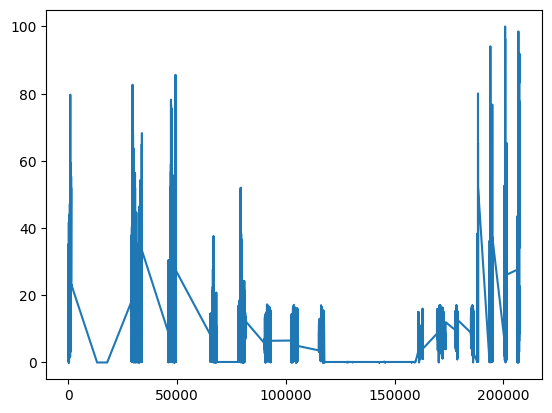

In [16]:
df['datarate'].plot()
plt.show()

XG Boost

In [17]:
df.shape

(43466, 151)

In [25]:
input_param = ['Latitude', 'Longitude', 'PCell_Downlink_Num_RBs',
 'PCell_Downlink_TB_Size',
 'SCell_Downlink_Num_RBs',
 'SCell_Downlink_TB_Size',
 'SCell_Downlink_RBs_MCS_28',
 'SCell_Downlink_RBs_MCS_31']
output_param = ['datarate']
UL_ALL_XG = xgboost_model('UL_ALL_XG',input_param,output_param)

RMSE :  3.864730
MAE :  2.699918721479358


In [26]:
def plot_loss(res,param):
    len_epoch = len(res.history[param])
    plt.figure(figsize=(5,5))
    epoch = np.linspace(1,len_epoch,len_epoch)
    plt.plot(epoch,res.history[param])
    plt.xlabel('epochs')
    plt.ylabel(param)
    plt.show()

In [27]:
def create_model(hidden_units,input_shape):
    model = keras.Sequential()
    model.add(keras.Input(shape=(input_shape,)))


    norm = tf.keras.layers.BatchNormalization(axis=-1,momentum=0.99)
    model.add(norm)


    for i in range(0,len(hidden_units)):
        model.add(keras.layers.Dense(hidden_units[i],activation='relu',kernel_initializer='normal', bias_initializer='zeros'))
    model.add(keras.layers.Dense(1 , activation='linear',kernel_initializer='normal', bias_initializer='zeros'))
    return model

In [28]:
def DNN_model(name,input_parameters,output_parameters,hidden_units):
    input_shape = len(input_parameters)
    x = df.loc[:,input_parameters]
    y = df.loc[:,output_parameters]

    for each in x.columns:
        Nan_count = count_Nan(x,each)
        if(Nan_count == 0):
            replace_Nan(x,each)

    train_X,test_X,train_Y,test_Y = train_test_split(x,y,test_size=0.1,random_state=123)
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience = 5)

    model = create_model(hidden_units,input_shape)
    model.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.0001),loss='mae',metrics=['mse',root_mean_squared_error])
    model_res = model.fit(train_X,train_Y,epochs=500,callbacks=[callback])

    calculate_mae(model,test_X,test_Y,name)
    return model,model_res

In [29]:
UL_ALL_DNN128,UL_ALL_DNN128_RES = DNN_model('UL_ALL_DNN128',input_param,output_param,[128,64,32,16])

Epoch 1/500
1223/1223 [==============================] - 2s 1ms/step - loss: 5.8286 - mse: 118.8779 - root_mean_squared_error: 10.6498
Epoch 2/500
1223/1223 [==============================] - 1s 1ms/step - loss: 3.9189 - mse: 45.0440 - root_mean_squared_error: 6.7115
Epoch 3/500
1223/1223 [==============================] - 2s 1ms/step - loss: 3.8184 - mse: 42.4072 - root_mean_squared_error: 6.5121
Epoch 4/500
1223/1223 [==============================] - 2s 1ms/step - loss: 3.7862 - mse: 41.5299 - root_mean_squared_error: 6.4444
Epoch 5/500
1223/1223 [==============================] - 2s 1ms/step - loss: 3.7594 - mse: 41.1451 - root_mean_squared_error: 6.4144
Epoch 6/500
1223/1223 [==============================] - 2s 1ms/step - loss: 3.7494 - mse: 40.9430 - root_mean_squared_error: 6.3987
Epoch 7/500
1223/1223 [==============================] - 2s 1ms/step - loss: 3.7201 - mse: 40.4824 - root_mean_squared_error: 6.3626
Epoch 8/500
1223/1223 [==============================] - 1s 1ms/ste

In [30]:
df

,ping_ms,datarate,jitter,Latitude,Longitude,Altitude,speed_kmh,COG,precipIntensity,precipProbability,...,SCell_Cell_Identity,SCell_TAC,SCell_Band_Indicator,SCell_MCC,SCell_MNC_Digit,SCell_MNC,SCell_Allowed_Access,SCell_freq_MHz,target_datarate,operator
216,443.361834,25.350431,0.000848,52.514013,13.335172,41.9,0.0000,0.0,0.0652,0.04,...,33802248.0,1494.0,7.0,262.0,2.0,1.0,0.0,2600.0,350000000,1
217,443.361834,9.040442,0.000512,52.514008,13.335195,35.3,0.0000,259.0,0.0652,0.04,...,51842565.0,49101.0,7.0,262.0,2.0,2.0,0.0,2600.0,350000000,2
218,443.361834,18.376250,0.000090,52.513830,13.334935,30.7,0.0000,0.0,0.0653,0.04,...,51842568.0,49101.0,3.0,262.0,2.0,2.0,0.0,1800.0,350000000,2
219,1396.000000,26.014639,0.000207,52.513848,13.334832,32.3,0.0000,265.9,0.0653,0.04,...,33802248.0,1494.0,7.0,262.0,2.0,1.0,0.0,2600.0,350000000,1
220,443.361834,7.675126,0.002268,52.514005,13.335195,35.4,0.0000,259.0,0.0652,0.04,...,51842565.0,49101.0,7.0,262.0,2.0,2.0,0.0,2600.0,350000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207429,443.361834,65.682601,0.000123,52.513883,13.335023,28.0,2.7780,81.6,0.3287,0.45,...,33802248.0,1494.0,7.0,262.0,2.0,1.0,0.0,2600.0,350000000,1
207430,443.361834,65.682601,0.000091,52.513885,13.335027,28.0,0.7408,81.6,0.3287,0.45,...,33802248.0,1494.0,7.0,262.0,2.0,1.0,0.0,2600.0,350000000,1
207431,443.361834,60.885545,0.000076,52.513887,13.335030,28.1,0.0000,81.6,0.3287,0.45,...,33802248.0,1494.0,7.0,262.0,2.0,1.0,0.0,2600.0,350000000,1
207432,540.000000,65.313596,0.000040,52.513890,13.335032,28.1,0.0000,81.6,0.3287,0.45,...,33802248.0,1494.0,7.0,262.0,2.0,1.0,0.0,2600.0,350000000,1


In [31]:
rslt_df = df.sort_values(by = 'datarate', ascending = False)
rslt_df = rslt_df.head(20)
import plotly.express as px

color_scale = [(0, 'black'), (1,'black')]

fig = px.scatter_mapbox(rslt_df, 
                        lat="Latitude", 
                        lon="Longitude",
                        hover_name="datarate", 
                        hover_data=["datarate"],
                        color="datarate",
                        color_continuous_scale=color_scale,
                        zoom=8, 
                        height=800,
                        width=800)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [33]:
input_param = ['Latitude',
               'Longitude','PCell_Downlink_Num_RBs',
 'PCell_Downlink_TB_Size',
 'SCell_Downlink_Num_RBs',
 'SCell_Downlink_TB_Size',
 'SCell_Downlink_RBs_MCS_28',
 'SCell_Downlink_RBs_MCS_31']
output_param = ['datarate']
UL_ALL_DNN64,UL_ALL_DNN64_RES = DNN_model('UL_ALL_DNN',input_param,output_param,[64,32,16])

Epoch 1/500
1223/1223 [==============================] - 2s 1ms/step - loss: 6.0690 - mse: 126.7341 - root_mean_squared_error: 9.2922
Epoch 2/500
1223/1223 [==============================] - 1s 1ms/step - loss: 3.9938 - mse: 46.9948 - root_mean_squared_error: 6.8553
Epoch 3/500
1223/1223 [==============================] - 1s 1ms/step - loss: 3.8573 - mse: 43.3272 - root_mean_squared_error: 6.5823
Epoch 4/500
1223/1223 [==============================] - 2s 2ms/step - loss: 3.8355 - mse: 42.8974 - root_mean_squared_error: 6.5496
Epoch 5/500
1223/1223 [==============================] - 2s 1ms/step - loss: 3.7773 - mse: 41.8352 - root_mean_squared_error: 6.4680
Epoch 6/500
1223/1223 [==============================] - 1s 1ms/step - loss: 3.7689 - mse: 41.4641 - root_mean_squared_error: 6.4393
Epoch 7/500
1223/1223 [==============================] - 1s 1ms/step - loss: 3.7730 - mse: 41.7192 - root_mean_squared_error: 6.4590
Epoch 8/500
1223/1223 [==============================] - 1s 1ms/step

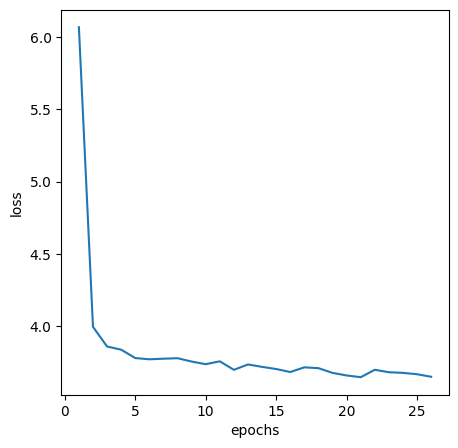

In [34]:
plot_loss(UL_ALL_DNN64_RES,'loss')

In [35]:
UL_ALL_DNN32,UL_ALL_DNN32_RES = DNN_model('UL_ALL_DNN',input_param,output_param,[32,16])

Epoch 1/500
1223/1223 [==============================] - 2s 998us/step - loss: 6.5240 - mse: 148.0629 - root_mean_squared_error: 9.6794
Epoch 2/500
1223/1223 [==============================] - 1s 963us/step - loss: 4.8582 - mse: 79.0982 - root_mean_squared_error: 8.8937
Epoch 3/500
1223/1223 [==============================] - 1s 962us/step - loss: 3.9948 - mse: 46.2060 - root_mean_squared_error: 6.7975
Epoch 4/500
1223/1223 [==============================] - 1s 986us/step - loss: 3.9138 - mse: 44.2705 - root_mean_squared_error: 6.6536
Epoch 5/500
1223/1223 [==============================] - 1s 952us/step - loss: 3.8619 - mse: 43.3495 - root_mean_squared_error: 6.5840
Epoch 6/500
1223/1223 [==============================] - 1s 998us/step - loss: 3.8435 - mse: 42.9272 - root_mean_squared_error: 6.5519
Epoch 7/500
1223/1223 [==============================] - 1s 959us/step - loss: 3.8323 - mse: 42.5008 - root_mean_squared_error: 6.5193
Epoch 8/500
1223/1223 [==============================]

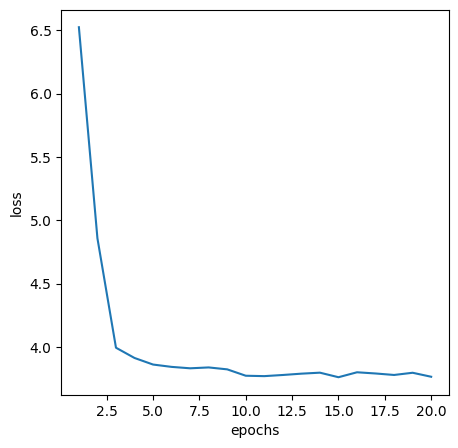

In [36]:
plot_loss(UL_ALL_DNN32_RES,'loss')

In [37]:
UL_ALL_DNN32.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dense_18 (Dense)            (None, 32)                288       
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 865
Trainable params: 849
Non-trainable params: 16
_________________________________________________________________


In [38]:
UL_ALL_DNN,UL_ALL_DNN_RES = DNN_model('UL_ALL_DNN',input_param,output_param,[])

Epoch 1/500
1223/1223 [==============================] - 2s 865us/step - loss: 6.6386 - mse: 150.1302 - root_mean_squared_error: 9.7630
Epoch 2/500
1223/1223 [==============================] - 1s 831us/step - loss: 6.3794 - mse: 139.3324 - root_mean_squared_error: 11.8039
Epoch 3/500
1223/1223 [==============================] - 1s 852us/step - loss: 6.1197 - mse: 126.5000 - root_mean_squared_error: 11.2472
Epoch 4/500
1223/1223 [==============================] - 1s 817us/step - loss: 5.8297 - mse: 112.6931 - root_mean_squared_error: 10.6157
Epoch 5/500
1223/1223 [==============================] - 1s 827us/step - loss: 5.5105 - mse: 98.5574 - root_mean_squared_error: 9.9276
Epoch 6/500
1223/1223 [==============================] - 1s 822us/step - loss: 5.1828 - mse: 85.4393 - root_mean_squared_error: 9.2433
Epoch 7/500
1223/1223 [==============================] - 1s 863us/step - loss: 4.8746 - mse: 73.3727 - root_mean_squared_error: 8.5658
Epoch 8/500
1223/1223 [=========================

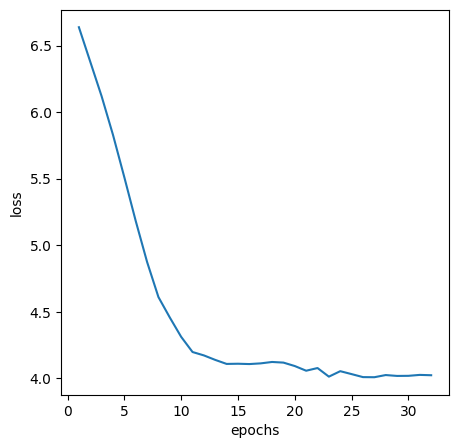

In [39]:
plot_loss(UL_ALL_DNN_RES,'loss')

In [40]:
opts={}
opts['256'] = [4,4,4,4]
opts['128'] = [4,4,4,2]
opts['64']  = [4,4,2,2]

opts['32'] = [4,2,2,2]
opts['16'] = [2,2,2,2]

def create_tt_model(input_shape,inp,tt):
    model = keras.Sequential()
    model.add(keras.Input(shape=(input_shape,)))
    norm = tf.keras.layers.BatchNormalization(axis=-1,momentum=0.99)
    model.add(norm)
    model.add(keras.layers.Dense(inp,activation='relu',kernel_initializer = 'normal',bias_initializer='zeros'))
    for each in tt:
        model.add(each)
    model.add(keras.layers.Dense(1 , activation='linear',kernel_initializer='normal', bias_initializer='zeros'))
    return model

def TT_model(name,input_parameters,output_parameters,inp,tt):
    input_shape = len(input_parameters)
    x = df.loc[:,input_parameters]
    y = df.loc[:,output_parameters]
    
    for each in x.columns:
        Nan_count = count_Nan(x,each)
        if(Nan_count == 0):
            replace_Nan(x,each)
    
    train_X,test_X,train_Y,test_Y = train_test_split(x,y,test_size=0.1,random_state=123)
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss',patience = 5)
    
    model = create_tt_model(input_shape,inp,tt)
    model.compile(optimizer = keras.optimizers.RMSprop(learning_rate=0.0001),loss='mae',metrics=['mse',root_mean_squared_error])
    model_res = model.fit(train_X,train_Y,epochs=500,callbacks=[callback])
    
    calculate_mae(model,test_X,test_Y,name)
    return model,model_res

In [41]:
rank = 2
tt1 = t3f.nn.KerasDense(input_dims = opts['256'] , output_dims = opts['128'] , tt_rank = rank , activation = 'relu')
tt2 = t3f.nn.KerasDense(input_dims = opts['128'] , output_dims = opts['64'] , tt_rank = rank , activation = 'relu')
tt3 = t3f.nn.KerasDense(input_dims = opts['64'] , output_dims = opts['32'] , tt_rank = rank , activation = 'relu')
tt4 = t3f.nn.KerasDense(input_dims = opts['32'] , output_dims = opts['16'] , tt_rank = rank , activation = 'relu')

In [42]:
UL_ALL_TT128,UL_ALL_TT128_RES = TT_model('UL_ALL_TT128',input_param,output_param,128,[tt2,tt3,tt4])

Epoch 1/500
1223/1223 [==============================] - 5s 3ms/step - loss: 6.0867 - mse: 128.1825 - root_mean_squared_error: 9.2251
Epoch 2/500
1223/1223 [==============================] - 4s 3ms/step - loss: 3.9370 - mse: 45.8303 - root_mean_squared_error: 6.7698
Epoch 3/500
1223/1223 [==============================] - 4s 3ms/step - loss: 3.8327 - mse: 42.8870 - root_mean_squared_error: 6.5488
Epoch 4/500
1223/1223 [==============================] - 4s 4ms/step - loss: 3.7936 - mse: 42.0094 - root_mean_squared_error: 6.4815
Epoch 5/500
1223/1223 [==============================] - 4s 3ms/step - loss: 3.7639 - mse: 41.2102 - root_mean_squared_error: 6.4195
Epoch 6/500
1223/1223 [==============================] - 5s 4ms/step - loss: 3.7484 - mse: 40.8600 - root_mean_squared_error: 6.3922
Epoch 7/500
1223/1223 [==============================] - 3s 3ms/step - loss: 3.7352 - mse: 40.6720 - root_mean_squared_error: 6.3775
Epoch 8/500
1223/1223 [==============================] - 4s 3ms/step

In [43]:
# input_param = [lat,long,DL_SNR,UL_SINR,speed]
# output_param = [UL_throughput]
UL_ALL_TT64,UL_ALL_TT64_RES = TT_model('UL_ALL_TT64',input_param,output_param,64,[tt3,tt4])

Epoch 1/500
1223/1223 [==============================] - 5s 3ms/step - loss: 6.2932 - mse: 139.0753 - root_mean_squared_error: 9.4296
Epoch 2/500
1223/1223 [==============================] - 3s 2ms/step - loss: 4.0846 - mse: 51.8513 - root_mean_squared_error: 7.2008
Epoch 3/500
1223/1223 [==============================] - 3s 2ms/step - loss: 3.8684 - mse: 43.8259 - root_mean_squared_error: 6.6201
Epoch 4/500
1223/1223 [==============================] - 3s 2ms/step - loss: 3.8294 - mse: 42.8891 - root_mean_squared_error: 6.5490
Epoch 5/500
1223/1223 [==============================] - 3s 2ms/step - loss: 3.7794 - mse: 41.8009 - root_mean_squared_error: 6.4654
Epoch 6/500
1223/1223 [==============================] - 3s 3ms/step - loss: 3.7804 - mse: 41.7974 - root_mean_squared_error: 6.4651
Epoch 7/500
1223/1223 [==============================] - 3s 3ms/step - loss: 3.7696 - mse: 41.4547 - root_mean_squared_error: 6.4385
Epoch 8/500
1223/1223 [==============================] - 3s 2ms/step

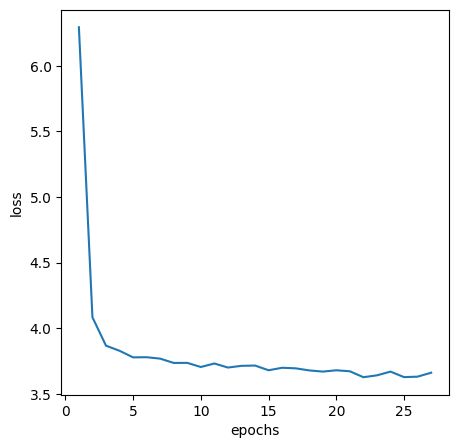

In [44]:
plot_loss(UL_ALL_TT64_RES,'loss')

In [45]:
UL_ALL_TT64.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_7 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dense_24 (Dense)            (None, 64)                576       
                                                                 
 tt_dense_2 (KerasDense)     (None, 32)                120       
                                                                 
 tt_dense_3 (KerasDense)     (None, 16)                72        
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 817
Trainable params: 801
Non-trainable params: 16
_______________________________________________________

In [46]:
UL_ALL_TT32,UL_ALL_TT32_RES = TT_model('UL_ALL_TT32',input_param,output_param,32,[tt4])

Epoch 1/500
1223/1223 [==============================] - 3s 2ms/step - loss: 6.2146 - mse: 133.5332 - root_mean_squared_error: 9.2939
Epoch 2/500
1223/1223 [==============================] - 2s 2ms/step - loss: 4.0724 - mse: 50.2307 - root_mean_squared_error: 7.0874
Epoch 3/500
1223/1223 [==============================] - 2s 2ms/step - loss: 3.8593 - mse: 43.3832 - root_mean_squared_error: 6.5866
Epoch 4/500
1223/1223 [==============================] - 2s 2ms/step - loss: 3.8064 - mse: 42.3603 - root_mean_squared_error: 6.5085
Epoch 5/500
1223/1223 [==============================] - 2s 2ms/step - loss: 3.7957 - mse: 41.7207 - root_mean_squared_error: 6.4592
Epoch 6/500
1223/1223 [==============================] - 2s 2ms/step - loss: 3.7378 - mse: 40.8360 - root_mean_squared_error: 6.3903
Epoch 7/500
1223/1223 [==============================] - 2s 2ms/step - loss: 3.7868 - mse: 41.7746 - root_mean_squared_error: 6.4633
Epoch 8/500
1223/1223 [==============================] - 2s 2ms/step

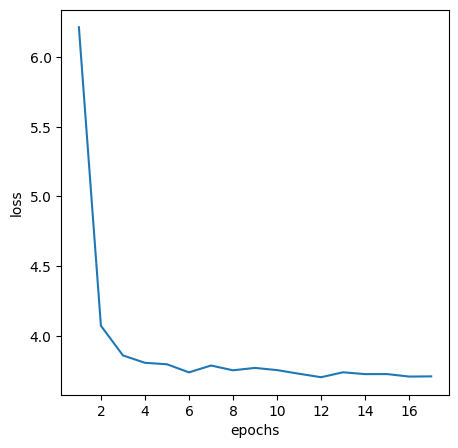

In [47]:
plot_loss(UL_ALL_TT32_RES,'loss')

In [48]:
UL_ALL_TT32.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dense_26 (Dense)            (None, 32)                288       
                                                                 
 tt_dense_3 (KerasDense)     (None, 16)                72        
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 409
Trainable params: 393
Non-trainable params: 16
_________________________________________________________________


In [49]:
original , ori_res = DNN_model('UL_ALL_DNN',input_param,output_param,[64,64])

Epoch 1/500
1223/1223 [==============================] - 5s 3ms/step - loss: 5.5090 - mse: 104.4796 - root_mean_squared_error: 8.5105
Epoch 2/500
1223/1223 [==============================] - 2s 2ms/step - loss: 3.9081 - mse: 44.1403 - root_mean_squared_error: 6.6438
Epoch 3/500
1223/1223 [==============================] - 2s 1ms/step - loss: 3.8563 - mse: 42.6414 - root_mean_squared_error: 6.5300
Epoch 4/500
1223/1223 [==============================] - 2s 1ms/step - loss: 3.8660 - mse: 43.1276 - root_mean_squared_error: 6.5672
Epoch 5/500
1223/1223 [==============================] - 2s 1ms/step - loss: 3.8173 - mse: 42.0839 - root_mean_squared_error: 6.4872
Epoch 6/500
1223/1223 [==============================] - 2s 1ms/step - loss: 3.7927 - mse: 41.3756 - root_mean_squared_error: 6.4324
Epoch 7/500
1223/1223 [==============================] - 2s 2ms/step - loss: 3.7746 - mse: 41.2801 - root_mean_squared_error: 6.4250
Epoch 8/500
1223/1223 [==============================] - 2s 2ms/step

In [50]:
x = df.loc[:,input_param]
y = df.loc[:,output_param]
    
for each in x.columns:
    Nan_count = count_Nan(x,each)
    if(Nan_count == 0):
        replace_Nan(x,each)
    
train_X,test_X,train_Y,test_Y = train_test_split(x,y,test_size=0.1,random_state=123)
pred = original.predict(test_X)

136/136 [==============================] - 0s 1ms/step


In [51]:
test_Y = np.array(test_Y)
for i in range(len(pred)):
    print(pred[i],"\t",test_Y[i])

[0.15115376] 	 [0.14522409]
[0.15045178] 	 [2.08102061]
[0.15063477] 	 [9.74154975]
[0.14816687] 	 [0.15223517]
[0.15164796] 	 [0.14854513]
[0.15080652] 	 [3.18434345]
[29.30427] 	 [36.3098589]
[18.745836] 	 [19.37256182]
[0.15063807] 	 [0.15223517]
[0.15076968] 	 [5.68250252]
[0.14934778] 	 [0.14522409]
[0.1506303] 	 [2.05519031]
[5.4324183] 	 [5.20279694]
[0.15134141] 	 [0.]
[0.15116799] 	 [0.14522409]
[0.15034637] 	 [11.69727251]
[13.471091] 	 [13.61609484]
[47.98828] 	 [42.43533018]
[0.15040469] 	 [0.14854513]
[0.15121412] 	 [0.14522409]
[0.1506791] 	 [0.14522409]
[0.15058313] 	 [0.14854513]
[0.15078115] 	 [6.75261497]
[9.46403] 	 [9.66774889]
[0.15114611] 	 [0.14522409]
[0.15174444] 	 [0.14854513]
[0.15080057] 	 [3.91128191]
[0.15079525] 	 [0.14522409]
[0.1513294] 	 [0.14854513]
[13.079489] 	 [12.91498668]
[21.50028] 	 [28.04416272]
[0.15119344] 	 [0.14854513]
[8.795288] 	 [9.59394803]
[49.987938] 	 [55.35048046]
[13.737113] 	 [12.61978324]
[24.174095] 	 [24.35411978]
[0.15050662]

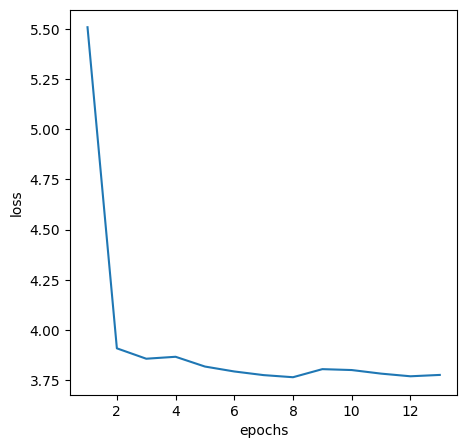

In [52]:
plot_loss(ori_res,'loss')

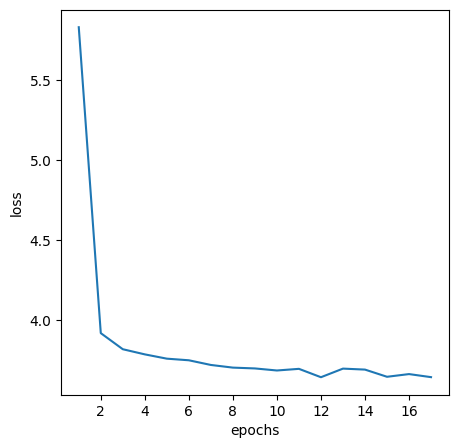

In [53]:
plot_loss(UL_ALL_DNN128_RES,'loss')

MAP PLOT